# NLP: Clasificación.

Ahora usaremos redes neuronales para clasificar texto.

El ejemplo que veremos fue tomado del [curso de fast.ai](www.fast.ai).

La idea será decidir, en base al texto de una review de una película de IMDB, si es un review positivo (calificación de 7 o más) o un review negativo (calificación de 4 o menos).

Esto igual podría servir para detección de spam, etc.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Esta vez importaremos fastai.text

In [2]:
import fastai.basics as fai
import fastai.text as ftxt
import pandas as pd

import gc
import torch

In [3]:
torch.cuda.is_available()

True

fastai trae dos para IMDB: el completo y una muestra. En este caso vamos a ver el dataset completo, pero en su tarea pueden usar el sample o el completo, como quieran (el completo tarda mucho)

In [4]:
path = fai.untar_data(fai.URLs.IMDB)

In [5]:
!ls {path}/

data_lm.pkl  imdb.vocab  models  README  test  tmp_clas  tmp_lm  train	unsup


In [6]:
!ls {path}/train

labeledBow.feat  neg  pos  unsupBow.feat


In [7]:
!ls {path}/train/neg | head

0_3.txt
10000_4.txt
10001_4.txt
10002_1.txt
10003_1.txt
10004_3.txt
1000_4.txt
10005_3.txt
10006_4.txt
10007_1.txt
ls: write error: Broken pipe


In [8]:
!cat {path}/train/neg/10001_4.txt

This film lacked something I couldn't put my finger on at first: charisma on the part of the leading actress. This inevitably translated to lack of chemistry when she shared the screen with her leading man. Even the romantic scenes came across as being merely the actors at play. It could very well have been the director who miscalculated what he needed from the actors. I just don't know.<br /><br />But could it have been the screenplay? Just exactly who was the chef in love with? He seemed more enamored of his culinary skills and restaurant, and ultimately of himself and his youthful exploits, than of anybody or anything else. He never convinced me he was in love with the princess.<br /><br />I was disappointed in this movie. But, don't forget it was nominated for an Oscar, so judge for yourself.

Ok, entonces está en estilo "ImageNet". Tenemos la carpeta train y valid y luego dividido en folders "neg" y "pos". Perfecto!

## NLP en 2018 en 5 minutos
Ahora, desde 2017-2018, como les he venido diciendo, hubo un cambio masivo en NLP, su "imagenet moment".

Estos cambios, que culminan con BERT y OpenAI GTP-2, se basan en dos ideas principales:
1. Transferencia de conocimiento
2. Atención.

Por ahora no usaremos atención, sólo transferencia de conocimiento, aunque debemos hablar un poco de la historia, y cosas como word2vec, etc.

Transferencia de conocimiento en NLP fue [empoderado](https://arxiv.org/abs/1801.06146) por Jeremy Howard, el creador de fastai! (junto con Sebastian Rudder).

Antes la única transferencia de conocimiento era usar embeddings pre-computados de palabras (word2vec, glove, etc.). Pero obviamente las palabras significan cosas diferentes dependiendo de su contexto!

La idea fue que el embedding corresponde a UNA sola capa de la red neuronal. Así que en vez de encodear una sola palabra, vamos a encodear enunciados completos, con varias capas.

Para entrenar esto vamos a usar un **modelo de lenguaje**: predecir la siguiente palabra en base a las anteriores (*e.g.* autocompletado en tu celular).

Vamos entonces a usar un modelo de lenguaje pre-entrenado en Wikipedia. Después vamos a re-entrenarlo para nuestros datos (sin usar si son negativos o positivos). Después usaremos ese modelo de lenguaje para hacer la clasificación.

Notemos que un modelo de lenguaje "perfecto" es a) imposible, b) algo a qué aspirar. Si le ponemos
"El presidente de México durante 1990 era", y nos lo completa con "Salinas", pues algo podemos pensar que sabe.


In [9]:
def load_lm_data(batch_size):
    return (ftxt.TextList.from_folder(path)
            .filter_by_folder(include=['train', 'test', 'unsup']) 
            .split_by_rand_pct(0.1)
            .label_for_lm()           
            .databunch(bs=batch_size))

In [8]:
data_lm = load_lm_data(32)

KeyboardInterrupt: 

Uff, esto tardó muchíiiiisimo! Vamos a guardar nuestro progreso (la próxima vez que corra esto, más bien correré sólo la linea de "load_data"

In [ ]:
data_lm.save('data_lm.pkl')

In [9]:
data_lm = ftxt.load_data(path, 'data_lm.pkl', bs=32)

In [11]:
data_lm.show_batch()

idx,text
0,"life than a cool set of wheels and a quick piece of tail . xxmaj sure , it 's essentially a blatant adolescent male fantasy pic -- the main teen xxunk character xxmaj bobby xxmaj hamilton gets the girls , the respect of his friends , and a chance to show - up a local van - racing bully -- but it 's way too dopey and good - natured"
1,"vhs , and years later on xxup dvd part of xxmaj xxunk 's xxmaj anime xxmaj legends collections . xxmaj it was amazing , and truly worth watching . xxmaj it had a lot of exploding action that will blow you out of your seat . xxmaj and of course , the theme songs "" xxmaj just xxmaj xxunk xxmaj rhythm xxmaj emotions "" were the best . \n \n"
2,"xxmaj but xxmaj david xxmaj duchovny and xxmaj michelle xxmaj forbes are a surprise as well . xxmaj they both did a very good job and i really wonder why we never heard anything from xxmaj forbes again since this movie , because she really proves to have a lot of talent . \n \n xxmaj overall this is a very good and impressive psychological thriller with a very"
3,"not touch - an obstacle that seems to be truly no obstacle with aids such as gloves , cellophane , and quirky schedules around the apartment . xxmaj but despite the awkwardness presented as they work their feelings around a strange secret which only a few know , they still manage to show their on screen chemistry in touching scenes like when xxmaj ned gives xxmaj chuck the xxunk ."
4,"complaint i have with this movie - the only slight flaw is the tone of intellectual / bourgeois snobbery i caught at times from the "" enlightened "" characters . xxmaj but that 's a minor quibble . \n \n xxmaj sadly , this film appears to have been bypassed by xxmaj western licensing companies . xxmaj it 's a crying shame that one of the all - round"


WTF??

¿Qué pasó ahí? Bueno, pues simplemente es que NLP es medio annoying, porque hay que hacer bastante pre-procesamiento antes de empezar.
1. **Tokenización**: separar en palabras, puntuación, etc.
    "¿Podrías pasarme la sal, hermano? => ¿ Podrías pasar me la sal , hermano ?"
    Agregaremos tokens para "fin de enunciado", para "todo lo que sigue en mayúscula", etc.

En realidad este paso es extremadamente importante, y entre mejor se haga, mejores resultados vas a obtener. Hay muchas decisiones que tomar, y saber sobre lenguaje ayuda, lo cual [está feo](http://www.incompleteideas.net/IncIdeas/BitterLesson.html). Ejemplo, por qué decidí separar "pasarme" en "pasar me"? ¿Por qué no "Podrías" en "Poder (segunda_persona) (condicional)"?

Probablemente tendría mejores resultados :(

Eso no está padre, y obviamente esto tiene que cambiar en el futuro, pero ni modo. Lo bueno es que fastai lo hace por nosotros. Lo malo es que lo hace para inglés.
2. **Numericalización**: cada palabra/símbolo se convierte en un entero del 0-n, donde n es el número de palabras. Las palabras que aparezcan menos de cierto número de veces (*e.g.* 3) se cambian por (unknown) 

3. **Embedding**: A cada token se le asocia un vector con parámetros aprendidos por el modelo de lenguaje.

In [12]:
data_lm.train_ds[0][0].data[:10]


array([   2,   19,  260, 2436,   15,  158,   19,  222,   49, 5784])

In [11]:
learn_lm = ftxt.language_model_learner(data_lm, ftxt.AWD_LSTM)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


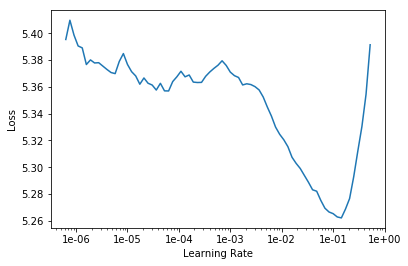

In [14]:
learn_lm.lr_find(); learn_lm.recorder.plot(skip_end=15)

In [ ]:
learn_lm.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn_lm.save('lm-1')

In [ ]:
learn_lm.unfreeze()

In [ ]:
learn_lm.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

In [23]:
learn_lm.save("lm-2")

In [12]:
learn_lm.load("lm-2")

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (90000 items)
x: LMTextList
xxbos i am proud to say i own an uncut copy of this choice chunk of 70 's xxmaj crown xxmaj international drive - in sexploitation comedy cheese on xxup dvd . xxmaj it 's a really goofy and enjoyably inconsequential flick with a nicely xxunk 70 's vibe to it . xxmaj it does attempt to make a sincere point about true love and friendship being more important in life than a cool set of wheels and a quick piece of tail . xxmaj sure , it 's essentially a blatant adolescent male fantasy pic -- the main teen xxunk character xxmaj bobby xxmaj hamilton gets the girls , the respect of his friends , and a chance to show - up a local van - racing bully -- but it 's way too dopey and good - natured to hate . xxmaj stuart xxmaj getz as our gawky protagonist makes for an endearingly dorky lead , xxmaj deborah xxmaj white as the main object of xxmaj getz 's affection is a definite cutie , xxmaj connie xxmaj lisa xxmaj 

In [24]:
learn_lm.validate()

[3.6904836, tensor(0.3351)]

Obtenemos accuracy de 33%!! Eso es muchísisimo! Piénsalo: Dadas unas palabras, un tercio de las veces podemos predecir la siguiente palabra!

Bueno, no es tanto, porque a veces es ________ predecir la palabra siguiente

In [27]:
learn_lm.predict("This movie is awful because", 40, temperature=0.75)

'This movie is awful because it is a very suspenseful British thriller . This is a good movie with a good premise and one that is fine , a good performance by British actress May Robson as a troubled wife'

In [22]:
learn_lm.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(60004, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60004, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60004, bias=True)
    (output_dp): RNNDropout()
  )
)

Listo, ahora vamos a guardar el "encoder" del language model para poderlo usar en el clasificador.

In [36]:
learn_lm.save_encoder('fine_tuned_encoder')

Para cargar los datos del clasificador, es igual que antes: la única diferencia es que tenemos que explícitamente darle el vocabulario que usaremos (que encontró el language model).

In [10]:
def load_clas_data(path, vocab, batch_size):
    return (ftxt.TextList
            .from_folder(path, vocab=vocab)
            .split_by_folder(valid='test')
            .label_from_folder(classes=['neg','pos'])
            .databunch(bs=batch_size))

In [11]:
data = load_clas_data(path,data_lm.vocab,10)

In [31]:
data.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj some have praised _ xxunk _ as a xxmaj disney adventure for adults . i do n't think so -- at least not for thinking adults . \n \n xxmaj this script suggests a beginning as a live - action movie , that struck someone as the type of crap you can not sell to adults anymore . xxmaj the "" crack staff "" of many older",neg
"xxbos xxmaj waitress : xxmaj honey , here 's them eggs you ordered . xxmaj honey , like bee , get it ? xxmaj that 's called pointless foreshadowing . \n \n xxmaj edward xxmaj basket : xxmaj huh ? ( xxmaj on the road ) xxmaj basket : xxmaj here 's your doll back , little girl . xxmaj you really should n't be so careless with your",neg
"xxbos xxmaj on xxmaj sunday xxmaj july 27 , 1997 , the first episode of a new science fiction series called "" xxmaj stargate xxup sg-1 "" was broadcast on xxmaj showtime . a spin - off of and sequel to the 1994 film "" xxmaj stargate "" starring xxmaj kurt xxmaj russell and xxmaj james xxmaj spader , the series begins approximately one year after the events portrayed in",pos
"xxbos xxmaj beat a path to this important documentary that looks like an attractive feature . xxmaj forbidden xxmaj xxunk ) is simply a better ( cinematic ) version of xxmaj norma xxmaj khouri 's book xxmaj forbidden xxmaj love , and xxup that was a best - seller . xxmaj an onion - peeling of literary fraud and of a pretty woman , xxmaj xxunk is the very best",pos


- xxbos = begining of sentence
- xxmaj = mayúscula la primera
- xxup = toda la siguiente palabra en mayúsculas
- xxunk = palabra no conocida
- etc.

In [12]:
learn = ftxt.text_classifier_learner(data, ftxt.AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_encoder')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


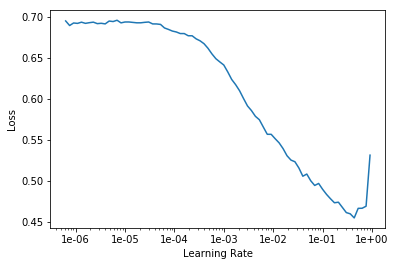

In [35]:
learn.lr_find(); learn.recorder.plot()

In [37]:
learn.fit_one_cycle(1,3e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.260108,0.194600,0.924720,04:14


In [38]:
learn.save('stage-1')

In [25]:
len(learn.layer_groups)

5

In [39]:
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


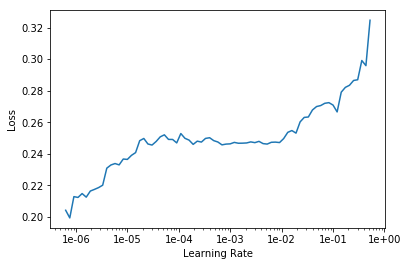

In [40]:
learn.lr_find(); learn.recorder.plot()

In [41]:
learn.fit_one_cycle(1,slice(3e-4,1e-2),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.241510,0.174818,0.932760,04:41


In [42]:
learn.save('stage-2')

In [16]:
learn.load('stage-2')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos i am proud to say i own an uncut copy of this choice chunk of 70 's xxmaj crown xxmaj international drive - in sexploitation comedy cheese on xxup dvd . xxmaj it 's a really goofy and enjoyably inconsequential flick with a nicely xxunk 70 's vibe to it . xxmaj it does attempt to make a sincere point about true love and friendship being more important in life than a cool set of wheels and a quick piece of tail . xxmaj sure , it 's essentially a blatant adolescent male fantasy pic -- the main teen xxunk character xxmaj bobby xxmaj hamilton gets the girls , the respect of his friends , and a chance to show - up a local van - racing bully -- but it 's way too dopey and good - natured to hate . xxmaj stuart xxmaj getz as our gawky protagonist makes for an endearingly dorky lead , xxmaj deborah xxmaj white as the main object of xxmaj getz 's affection is a definite cutie , xxmaj connie xxmaj lisa xxmaj marie

In [17]:
learn.freeze_to(-3)

In [18]:
learn.fit_one_cycle(1,slice(1e-4,5e-3),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.195136,0.154484,0.942720,07:28


In [19]:
learn.save('stage-3')

In [13]:
learn.load('stage-3');

In [14]:
learn.unfreeze()

In [15]:
gc.collect()
torch.cuda.empty_cache()

In [16]:
learn.fit_one_cycle(2,slice(3e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.219084,0.155877,0.943600,26:01
1,0.165924,0.150987,0.946200,26:04


Nada mal, considerando que el estado del arte [es 95.2](http://nlpprogress.com/english/sentiment_analysis.html) (del creador de fast.ai, Jeremy Howard), usando exactamente lo mismo (pero con más feature engineering).